In [ ]:
# MDP Q1

import numpy as np
from collections import defaultdict

policy = {
    (0, 0): "R", (0, 1): "D", (0, 2): "L", (0, 3): "D", (0, 4): "D",
    (1, 0): "R", (1, 1): "R", (1, 2): "R", (1, 3): "R", (1, 4): "D",
    (2, 0): "U",                      (2, 4): "D",
    (3, 0): "U", (3, 1): "L",          (3, 3): "R", (3, 4): "D",
    (4, 0): "U", (4, 1): "R", (4, 2): "R", (4, 3): "R", (4, 4): "G"
}

value_pi_star = {
            (0, 0): 2.6638, (0, 1): 2.9969, (0, 2): 2.8117, (0, 3): 3.6671, (0, 4): 4.8497,
            (1, 0): 2.9713, (1, 1): 3.5101, (1, 2): 4.0819, (1, 3): 4.8497, (1, 4): 7.1648,
            (2, 0): 2.5936, (2, 4): 8.4687,
            (3, 0): 2.0992, (3, 1): 1.0849, (3, 3): 8.6097, (3, 4): 9.5269,
            (4, 0): 1.0849, (4, 1): 4.9465, (4, 2): 8.4687, (4, 3): 9.5269, (4, 4): 0.0
}


class CatMonsterWorld:
    def __init__(self):


        # States
        self.S_0 = (0, 0)
        self.S_infinity = [(4, 4)]
        self.furniture = [(2, 1), (2, 2), (2, 3), (3, 2)]
        self.monsters = [(0, 3), (4, 1)]
        self.states = [(r, c) for r in range(5) for c in range(5) if (r, c) not in self.furniture]

        # Actions
        self.actions = ["U", "D", "L", "R"]
        self.correct = {
            "U": (-1, 0),
            "D": (1, 0),
            "L": (0, -1),
            "R": (0, 1)
        }
        self.action_symbols = {
          'U': '↑',
          'D': '↓',
          'L': '←',
          'R': '→'
        }

        # Reward
        self.R_step = -0.05
        self.R_monster = -8
        self.R_food = 10

        # Transition probabilities
        self.move_correct_prob = 0.70
        self.move_left_prob = 0.12
        self.move_right_prob = 0.12
        self.no_move_prob = 0.06

        self.value_table = defaultdict(float)
        for state in value_pi_star.keys():
            self.value_table[state] = 0.0
        self.returns = defaultdict(list)

    def value_table_reset(self):
        self.value_table = defaultdict(float)
        for state in value_pi_star.keys():
            self.value_table[state] = 0.0

    def is_terminal(self, state):
        return state in self.S_infinity

    def is_forbidden(self, state):
        return state in self.furniture

    def is_monster(self, state):
        return state in self.monsters

    def in_walls(self, state):
        r, c = state
        return 0 <= r < 5 and 0 <= c < 5

    def transition_probabilities(self,state, action):
        """Return the state transition probabilities of a given state and action."""
        r, c = state
        correct_move = self.correct[action]
        transitions = []

        # Correct direction
        next_state = (r + correct_move[0], c + correct_move[1])
        if self.in_walls(next_state) and not self.is_forbidden(next_state):
            transitions.append((self.move_correct_prob, next_state))
        else:
            transitions.append((self.move_correct_prob, state))

        # Move left and right to current action direction
        if action =="U":
            left_move = self.correct["L"]
            right_move = self.correct["R"]
        elif action == "D":
            left_move = self.correct["R"]
            right_move = self.correct["L"]
        elif action == "L":
            left_move = self.correct["D"]
            right_move = self.correct["U"]
        else:
            left_move = self.correct["U"]
            right_move = self.correct["D"]


        next_left_state = (r + left_move[0], c + left_move[1])
        next_right_state = (r + right_move[0], c + right_move[1])

        if self.in_walls(next_left_state) and not self.is_forbidden(next_left_state):
            transitions.append((self.move_left_prob, next_left_state))
        else:
            transitions.append((self.move_left_prob, state))

        if self.in_walls(next_right_state) and not self.is_forbidden(next_right_state):
            transitions.append((self.move_right_prob, next_right_state))
        else:
            transitions.append((self.move_left_prob, state))

        # No move
        transitions.append((self.no_move_prob, state))

        return transitions

    def Reward(self,next_state):
        if next_state in self.S_infinity:
            return self.R_food
        elif next_state in self.monsters:
            return self.R_monster
        return self.R_step

    def generate_episode(self, policy):
        """ Generate  episode/trajectory of the given policy."""
        episode = []
        state = self.d0_start_state()

        while not self.is_terminal(state):
            action = policy[state]
            prob_next_states = self.transition_probabilities(state, action)
            next_state = self.choose_next_state(prob_next_states)
            reward = self.Reward(next_state)
            episode.append((state, action, reward))
            state = next_state

        return episode

    def d0_start_state(self):
        """Initialize a random start state excluding forbidden states."""
        while True:
            state = (np.random.randint(0, 5), np.random.randint(0, 5))
            if not self.is_forbidden(state):
                return state

    def choose_next_state(self, prob_next_states):
        """Choose the next state based on the given transition probabilities."""
        state_prob_map = defaultdict(float)

        for prob ,state in prob_next_states:
            state_prob_map[state] += prob

        unique_states = list(state_prob_map.keys())
        combined_probs = list(state_prob_map.values())

        # Map unique states to string representations
        state_to_str_map = {state: f's_{i+1}' for i, state in enumerate(unique_states)}
        str_to_state_map = {v: k for k, v in state_to_str_map.items()}

        # Randomly select a string
        selected_state_str = np.random.choice(list(state_to_str_map.values()), p=combined_probs)
        selected_state = str_to_state_map[selected_state_str]

        return selected_state

    def check_convergence(self, tolerance,value):
        """Check if the value function estimate has converged within the specified tolerance."""
        max_diff = max(abs(value[s] - v) for s, v in self.value_table.items())

        return max_diff < tolerance


In [ ]:
class CatMonsterWorldTD(CatMonsterWorld):
    def td_policy_evaluation(self, policy, value_pi, alpha=0.1, gamma=0.925, tolerance=0.1):
        """TD Policy Evaluation."""
        iterations = 0
        value_prev = self.value_table.copy()

        while True:

            iterations += 1
            state = self.d0_start_state()  # Start from uniform random initial state
            if self.is_terminal(state):
                continue

            while not self.is_terminal(state):

                # get action , next state and reward
                action = policy[state]
                prob_next_states = self.transition_probabilities(state, action)
                next_state = self.choose_next_state(prob_next_states)
                reward = self.Reward(next_state)

                # TD update
                td_target = reward + gamma * self.value_table[next_state]
                td_error = td_target - self.value_table[state]
                self.value_table[state] += alpha * td_error

                # Update state
                state = next_state

            # Check for convergence
            if self.check_convergence(tolerance, value_prev):
                break
            # print(self.value_table)
            value_prev=self.value_table.copy()

        return self.value_table, iterations

    def run(self, policy, value_pi_star, alpha=0.1, gamma=0.925, tolerance=0.1, runs=50):
        """Run TD Policy Evaluation multiple times and gather statistics."""
        value_functions = []
        episode_counts = []

        for _ in range(runs):
            # Reset value table
            self.value_table_reset()

            # TD Policy Evaluation
            value_function, episodes = self.td_policy_evaluation(policy, value_pi_star, alpha, gamma, tolerance)
            value_functions.append(value_function)
            episode_counts.append(episodes)

        # Compute average value function and max-norm difference
        average_value_function = defaultdict(float)
        for state in value_pi_star.keys():
            average_value_function[state] = np.mean([vf[state] for vf in value_functions])

        max_norm_diff = max(abs(average_value_function[s] - value_pi_star[s]) for s in value_pi_star.keys())

        # Compute statistics on episode counts
        avg_episodes = np.mean(episode_counts)
        std_episodes = np.std(episode_counts)

        return alpha, average_value_function, max_norm_diff, avg_episodes, std_episodes


In [ ]:
#QUESTION 1 :-



alpha_values = [0.01,0.05,0.1,0.3,0.5]
gamma = 0.925
tolerance = 0.001
runs = 50
results = []

for alpha in alpha_values:
    env_td = CatMonsterWorldTD()
    alpha, avg_value_function, max_norm_diff, avg_episodes, std_episodes = env_td.run(
        policy, value_pi_star, alpha, gamma, tolerance, runs
    )
    results.append((alpha, avg_episodes, std_episodes, max_norm_diff,avg_value_function))


best_alpha = min(results, key=lambda x: x[3])  # Minimize max_norm_diff to choose best alpha

# Print results for all alphas
print(f"{'Alpha':>10} {'Avg Episodes':>15} {'Std Episodes':>15} {'Max-Norm Diff':>15}")
for alpha, avg_episodes, std_episodes, max_norm_diff in results:
    print(f"{alpha:>10.3f} {avg_episodes:>15.3f} {std_episodes:>15.3f} {max_norm_diff:>15.3f}")

# Report best alpha
print("\nBest Alpha:")
print(f"Alpha: {best_alpha[0]}, Avg Episodes: {best_alpha[1]}, Std Episodes: {best_alpha[2]}, Max-Norm Diff: {best_alpha[3]} ")

def print_value_function(value_function, world, grid_size=5):
    print("Value Function:")
    for r in range(grid_size):
        print(" ".join(
            f"{value_function.get((r, c), 0) if (r, c) not in env_td.furniture else 0:7.4f}"
            for c in range(grid_size)
        ))

print_value_function(best_alpha[4], env_td)


In [ ]:
class SARSA(CatMonsterWorld):
    def __init__(self):
        super().__init__()
        self.q = defaultdict(lambda: 20.0)  # Default optimistic value
        for r in range(5):
          for c in range (5):
            state = (r,c)
            if self.is_forbidden(state) or self.is_terminal(state):
                for action in self.actions:
                    self.q[(state, action)] = 0.0  # Forbidden/terminal states


    def epsilon_greedy_action_probabilities(self, state,epsilon):
        """Compute epsilon-greedy probabilities for actions in the given state."""
        actions = list(self.actions)
        q_values = [self.q[(state, action)] for action in actions]
        max_q_value = max(q_values)

        # Identify optimal actions
        optimal_actions = [action for action, q_val in zip(actions, q_values) if q_val == max_q_value]
        num_optimal = len(optimal_actions)
        num_actions = len(actions)

        # Calculate probabilities for epsilon-greedy selection
        action_probabilities = {action: epsilon / num_actions for action in actions}
        for action in optimal_actions:
            action_probabilities[action] += (1 - epsilon) / num_optimal

        return action_probabilities

    def epsilon_greedy_policy(self, state, epsilon):
        action_probabilities = self.epsilon_greedy_action_probabilities(state, epsilon)
        action = np.random.choice(list(action_probabilities.keys()), p=list(action_probabilities.values()))
        return action

    def sarsa(self, alpha=0.1, gamma=0.925,   epsilon=0.1, episodes=1000):
        """SARSA algorithm for estimating Q-function."""
        steps_per_episode = []
        total_steps = 0
        mse_values = []
        for episode in range(episodes):

            # Initialize state and choose action
            state = self.d0_start_state()
            action = self.epsilon_greedy_policy(state, epsilon)
            steps = 0

            while not self.is_terminal(state):
                # Take action, observe reward and next state
                prob_next_states = self.transition_probabilities(state, action)
                next_state = self.choose_next_state(prob_next_states)
                reward = self.Reward(next_state)

                # Choose next action
                next_action = self.epsilon_greedy_policy(next_state, epsilon)

                # Update Q-value using SARSA rule
                td_target = reward + gamma * self.q[(next_state,next_action)]
                td_error = td_target - self.q[(state,action)]
                self.q[(state,action)] += alpha * td_error

                # Update state and action
                state, action = next_state, next_action

                total_steps += 1
                steps_per_episode.append((total_steps, episode))
            v_estimate = self.calculate_v(epsilon)
            mse = self.mean_squared_error(v_estimate, value_pi_star)
            mse_values.append(mse)


        return steps_per_episode,mse_values

    def calculate_v(self, epsilon):
        """Calculate value function (v) using the current Q-function and policy."""
        v_table = {}
        for state in self.states:
            q_values = [self.q[(state, action)] for action in self.actions]
            max_q = max(q_values) if q_values else 0
            v_table[state] = max_q * (1 - epsilon) + epsilon * sum(q_values) / len(q_values)
        return v_table

    def mean_squared_error(self, v_estimated, v_true):
        """Compute the Mean Squared Error between the estimated and true value functions."""
        mse = np.mean([(v_estimated[state] - v_true[state]) ** 2 for state in self.states])
        return mse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Run SARSA 20 times
runs = 20
all_steps_per_episode = []
mse_all_runs = []
for _ in range(runs):
    # Initialize SARSA environment
    sarsa_agent = SARSA()
    steps_per_episode,mse_per_run = sarsa_agent.sarsa(episodes=1000)
    # print(steps_per_episode)
    all_steps_per_episode.append(steps_per_episode)
    mse_all_runs.append(mse_per_run)


{1: 0.0, 2: 0.05, 3: 0.05, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.15, 11: 0.15, 12: 0.15, 13: 0.2, 14: 0.2, 15: 0.25, 16: 0.25, 17: 0.25, 18: 0.25, 19: 0.25, 20: 0.35, 21: 0.35, 22: 0.35, 23: 0.35, 24: 0.35, 25: 0.45, 26: 0.5, 27: 0.6, 28: 0.6, 29: 0.6, 30: 0.6, 31: 0.6, 32: 0.6, 33: 0.6, 34: 0.6, 35: 0.6, 36: 0.6, 37: 0.6, 38: 0.6, 39: 0.6, 40: 0.6, 41: 0.6, 42: 0.65, 43: 0.65, 44: 0.65, 45: 0.65, 46: 0.65, 47: 0.65, 48: 0.65, 49: 0.65, 50: 0.65, 51: 0.65, 52: 0.65, 53: 0.65, 54: 0.65, 55: 0.65, 56: 0.65, 57: 0.65, 58: 0.65, 59: 0.65, 60: 0.7, 61: 0.7, 62: 0.7, 63: 0.7, 64: 0.7, 65: 0.75, 66: 0.75, 67: 0.75, 68: 0.75, 69: 0.75, 70: 0.8, 71: 0.8, 72: 0.8, 73: 0.85, 74: 0.85, 75: 0.85, 76: 0.9, 77: 0.9, 78: 0.9, 79: 0.9, 80: 0.9, 81: 0.9, 82: 0.9, 83: 0.9, 84: 0.9, 85: 0.9, 86: 0.9, 87: 0.9, 88: 0.9, 89: 0.9, 90: 0.9, 91: 0.9, 92: 0.9, 93: 0.9, 94: 0.9, 95: 0.9, 96: 0.95, 97: 0.95, 98: 1.0, 99: 1.05, 100: 1.05, 101: 1.05, 102: 1.05, 103: 1.05, 104: 1.05, 105: 1.05, 106: 1

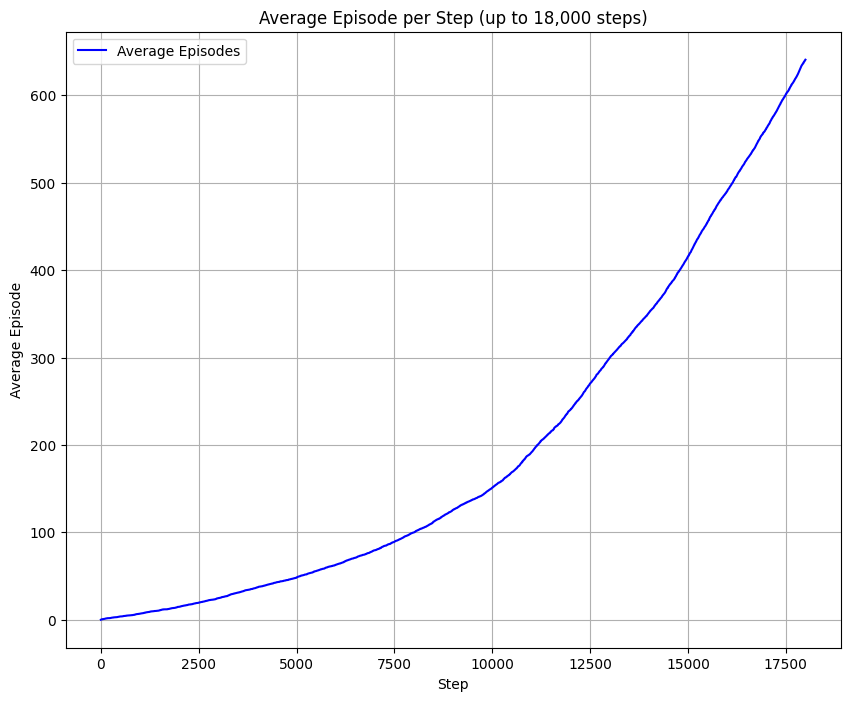

In [ ]:
# Step 1: Create a dictionary to group all episodes by step
step_to_episodes = {}
# print(all_steps_per_episode)

for steps in all_steps_per_episode:
    # print(steps)
    for step, episode in steps:
        if step not in step_to_episodes:
            step_to_episodes[step] = []
        step_to_episodes[step].append(episode)

# Step 2: Compute the average episode value for each step
avg_steps = {step: np.mean(episodes) for step, episodes in step_to_episodes.items()}
print(avg_steps)

# Step 3: Filter for steps <= 10,000
filtered_avg_steps = {step: avg for step, avg in avg_steps.items() if step <= 18000}

# Step 4: Prepare data for plotting
steps = sorted(filtered_avg_steps.keys())  # Sorted step numbers
avg_episodes = [filtered_avg_steps[step] for step in steps]  # Average episodes for each step

# Step 5: Create the plot
plt.figure(figsize=(10, 8))
plt.plot(steps, avg_episodes, color='b', label='Average Episodes')
plt.xlabel('Step')
plt.ylabel('Average Episode')
plt.title('Average Episode per Step (up to 18,000 steps)')
plt.grid(True)
plt.legend()
plt.show()


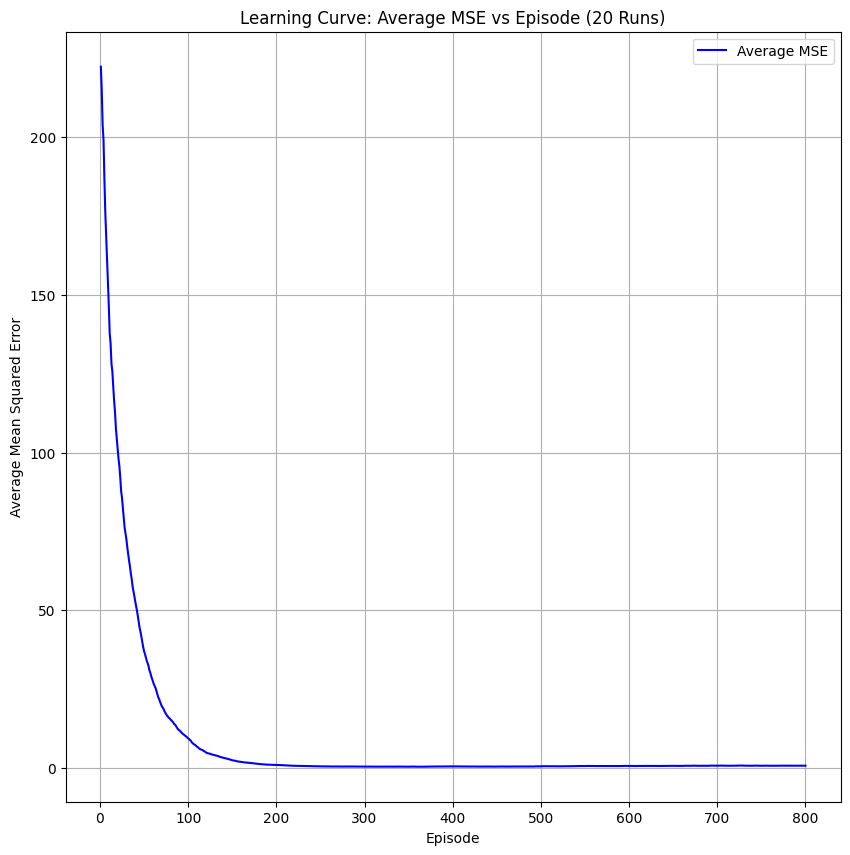

In [ ]:
 # Average MSE across all runs for each episode
avg_mse_values = np.mean(np.array(mse_all_runs), axis=0)


plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, len(avg_mse_values) + 1), avg_mse_values, color='b', label='Average MSE')
plt.xlabel('Episode')
plt.ylabel('Average Mean Squared Error')
plt.title('Learning Curve: Average MSE vs Episode (20 Runs)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:

def display_greedy_policy(sarsa_instance):
    """Display the greedy policy based on the learned Q-values."""
    policy_grid = [['' for _ in range(5)] for _ in range(5)]
    for r in range(5):
        for c in range(5):
            state = (r, c)
            if sarsa_instance.is_forbidden(state):
                policy_grid[r][c] = 'X'  # Mark forbidden states
            elif sarsa_instance.is_terminal(state):
                policy_grid[r][c] = 'G'  # Mark terminal states
            else:
                # Get the greedy action based on Q-values
                actions = list(sarsa_instance.actions)
                q_values = [sarsa_instance.q[(state, action)] for action in actions]
                max_q = max(q_values)
                greedy_action = actions[q_values.index(max_q)]
                # policy_grid[r][c] = greedy_action
                policy_grid[r][c] = sarsa_instance.action_symbols.get(greedy_action, '?')

    # Print the policy grid
    print("Greedy Policy:")
    for row in policy_grid:
        print(' '.join(row))


# Initialize SARSA environment
sarsa_agent = SARSA()
# Run SARSA algorithm
sarsa_agent.sarsa(episodes=1000)
# Display the greedy policy
display_greedy_policy(sarsa_agent)


Greedy Policy:
→ ↓ ← ↓ ↓
→ → → → ↓
↑ X X X ↓
← ← X → ↓
↑ → → → G


In [ ]:
# prompt: Qlearning similar SARSA above

class QLearning(CatMonsterWorld):
    def __init__(self):
        super().__init__()
        self.q = defaultdict(lambda: 20.0)  # Default optimistic value
        for r in range(5):
          for c in range (5):
            state = (r,c)
            if self.is_forbidden(state) or self.is_terminal(state):
                for action in self.actions:
                    self.q[(state, action)] = 0.0  # Forbidden/terminal states

    def q_learning(self, alpha=0.1, gamma=0.925, epsilon=0.1, episodes=1000):
        steps_per_episode = []
        total_steps = 0
        mse_values = []

        for episode in range(episodes):
            state = self.d0_start_state()


            while not self.is_terminal(state):
                action = self.epsilon_greedy_policy(state, epsilon)
                prob_next_states = self.transition_probabilities(state, action)
                next_state = self.choose_next_state(prob_next_states)
                reward = self.Reward(next_state)

                # Q-learning update
                best_next_action = max(self.actions, key=lambda a: self.q[(next_state, a)])
                td_target = reward + gamma * self.q[(next_state, best_next_action)]
                td_error = td_target - self.q[(state, action)]
                self.q[(state, action)] += alpha * td_error

                state = next_state
                total_steps += 1
                steps_per_episode.append((total_steps, episode))

            v_estimate = self.calculate_v(epsilon)
            mse = self.mean_squared_error(v_estimate, value_pi_star)
            mse_values.append(mse)
        return steps_per_episode, mse_values

    def epsilon_greedy_action_probabilities(self, state,epsilon):
          """Compute epsilon-greedy probabilities for actions in the given state."""
          actions = list(self.actions)
          q_values = [self.q[(state, action)] for action in actions]
          max_q_value = max(q_values)

          # Identify optimal actions
          optimal_actions = [action for action, q_val in zip(actions, q_values) if q_val == max_q_value]
          num_optimal = len(optimal_actions)
          num_actions = len(actions)

          # Calculate probabilities for epsilon-greedy selection
          action_probabilities = {action: epsilon / num_actions for action in actions}
          for action in optimal_actions:
              action_probabilities[action] += (1 - epsilon) / num_optimal

          return action_probabilities

    def epsilon_greedy_policy(self, state, epsilon):
        action_probabilities = self.epsilon_greedy_action_probabilities(state, epsilon)
        action = np.random.choice(list(action_probabilities.keys()), p=list(action_probabilities.values()))
        return action
    def calculate_v(self, epsilon):
      """Calculate value function (v) using the current Q-function and policy."""
      v_table = {}
      for state in self.states:
          q_values = [self.q[(state, action)] for action in self.actions]
          max_q = max(q_values) if q_values else 0
          v_table[state] = max_q * (1 - epsilon) + epsilon * sum(q_values) / len(q_values)
      return v_table

    def mean_squared_error(self, v_estimated, v_true):
        """Compute the Mean Squared Error between the estimated and true value functions."""
        mse = np.mean([(v_estimated[state] - v_true[state]) ** 2 for state in self.states])
        return mse



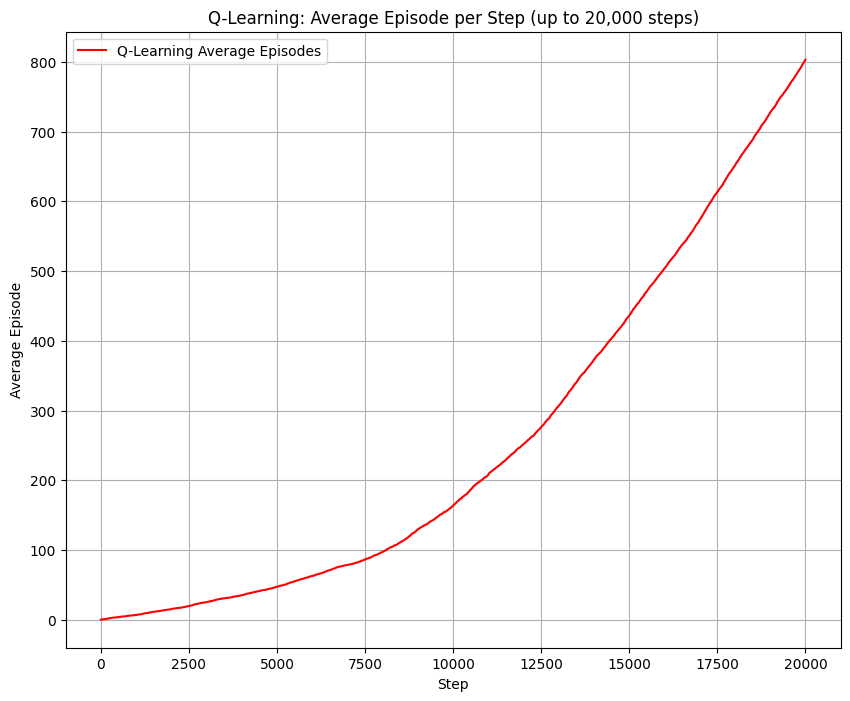

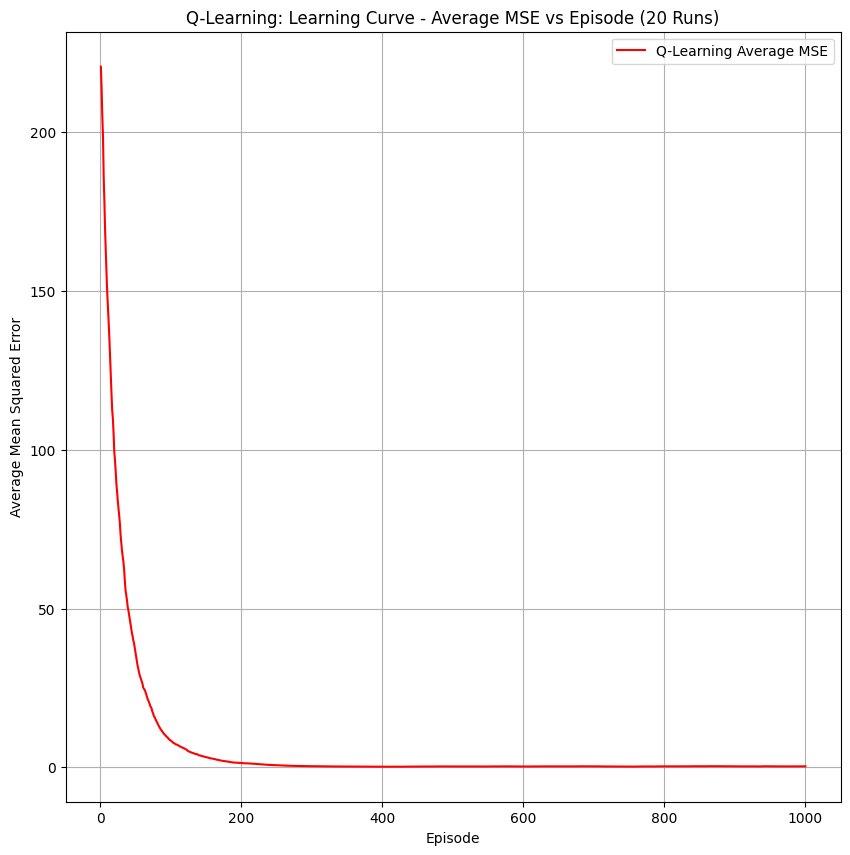

In [ ]:



# Q-Learning Plots
runs = 20
all_steps_per_episode_ql = []
mse_all_runs_ql = []
for _ in range(runs):
    ql_agent = QLearning()
    steps_per_episode, mse_per_run = ql_agent.q_learning(episodes=1000)
    all_steps_per_episode_ql.append(steps_per_episode)
    mse_all_runs_ql.append(mse_per_run)

# Step 1: Create a dictionary to group all episodes by step
step_to_episodes_ql = {}
for steps in all_steps_per_episode_ql:
    for step, episode in steps:
        if step not in step_to_episodes_ql:
            step_to_episodes_ql[step] = []
        step_to_episodes_ql[step].append(episode)

# Step 2: Compute the average episode value for each step
avg_steps_ql = {step: np.mean(episodes) for step, episodes in step_to_episodes_ql.items()}

# Step 3: Filter for steps <= 20,000
filtered_avg_steps_ql = {step: avg for step, avg in avg_steps_ql.items() if step <= 20000}

# Step 4: Prepare data for plotting
steps_ql = sorted(filtered_avg_steps_ql.keys())
avg_episodes_ql = [filtered_avg_steps_ql[step] for step in steps_ql]

# Step 5: Create the plot
plt.figure(figsize=(10, 8))
plt.plot(steps_ql, avg_episodes_ql, color='r', label='Q-Learning Average Episodes')
plt.xlabel('Step')
plt.ylabel('Average Episode')
plt.title('Q-Learning: Average Episode per Step (up to 20,000 steps)')
plt.grid(True)
plt.legend()
plt.show()

# Average MSE across all runs for each episode for Q-learning
avg_mse_values_ql = np.mean(np.array(mse_all_runs_ql), axis=0)

plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, len(avg_mse_values_ql) + 1), avg_mse_values_ql, color='r', label='Q-Learning Average MSE')
plt.xlabel('Episode')
plt.ylabel('Average Mean Squared Error')
plt.title('Q-Learning: Learning Curve - Average MSE vs Episode (20 Runs)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def display_greedy_policy(q_learning_instance):
    """Display the greedy policy based on the learned Q-values."""
    policy_grid = [['' for _ in range(5)] for _ in range(5)]
    for r in range(5):
        for c in range(5):
            state = (r, c)
            if q_learning_instance.is_forbidden(state):
                policy_grid[r][c] = 'X'  # Mark forbidden states
            elif q_learning_instance.is_terminal(state):
                policy_grid[r][c] = 'G'  # Mark terminal states
            else:
                # Get the greedy action based on Q-values
                 # Get the greedy action based on Q-values
                actions = list(q_learning_instance.actions)
                q_values = [q_learning_instance.q[(state, action)] for action in actions]
                max_q = max(q_values)
                greedy_action = actions[q_values.index(max_q)]
                policy_grid[r][c] = q_learning_instance.action_symbols.get(greedy_action, '?')

    # Print the policy grid
    print("Greedy Policy:")
    for row in policy_grid:
        print(' '.join(row))

# Initialize Q-Learning environment
q_learning_agent = QLearning()
# Run Q-Learning algorithm
q_learning_agent.q_learning(episodes=1000)
# Display the greedy policy
display_greedy_policy(q_learning_agent)

Greedy Policy:
→ ↓ ← ↓ →
→ → → → ↓
↑ X X X ↓
↑ ↑ X → ↓
↑ → → → G


In [1]:
import numpy as np

class PendulumEnv:
    def __init__(self):
        self.G = 10.0
        self.L = 1.0
        self.M = 1.0
        self.max_speed = 8.0
        self.max_torque = 2.0
        self.dt = 0.05
        self.state = None
        self.set_initial_state()

    def set_initial_state(self):
        w = np.random.uniform(-5 * np.pi / 6, 5 * np.pi / 6)
        w_dot = np.random.uniform(-1, 1)
        self.state = np.array([w, w_dot])
        return self.state

    def step(self, action):

        w_t, w_dot_t = self.state
        w_accel = (3 * self.G / (2 * self.L) * np.sin(w_t) + 3 * action / (self.M * self.L**2))
        w_dot = np.clip(w_dot_t + w_accel * self.dt, -self.max_speed, self.max_speed)
        w = w_t+ w_dot * self.dt

        self.state = np.array([w, w_dot])

        w_norm = ((w_t+ np.pi) % (2 * np.pi)) - np.pi
        reward = -(w_norm**2 + 0.1 * w_dot_t**2 + 0.001 *action**2)

        return self.state, reward

    def is_done(self, steps):
        return steps >= 200

    def discretize_state(self,state,omega_bins=5, omega_dot_bins=5):
        """
        Discretizes the state into bins for omega (angle) and omega_dot (angular velocity).
        """
        omega, omega_dot = state
        omega_normalized = ((omega + np.pi) % (2 * np.pi)) - np.pi
        omega_dot = np.clip(omega_dot, -8, 8)
        # Define bin edges for omega and omega_dot
        omega_bin_edges = np.linspace(-np.pi, np.pi, omega_bins + 1)
        omega_dot_bin_edges = np.linspace(-8, 8, omega_dot_bins + 1)

        # Find the bin index for omega and omega_dot
        omega_idx = np.digitize(omega_normalized, omega_bin_edges) - 1
        omega_dot_idx = np.digitize(omega_dot, omega_dot_bin_edges) - 1

        return (omega_idx, omega_dot_idx)


    def discretize_action(action, action_bins):
        """
        Discretizes the action (torque) into bins.
        """

        action_bin_edges = np.linspace(-2, 2, action_bins + 1)
        # Find the bin index for the action
        action_idx = np.digitize(action, action_bin_edges) - 1

        return action_idx

In [2]:
import numpy as np
from collections import defaultdict

class SARSA:
    def __init__(self, env, omega_bins=10, omega_dot_bins=10, action_bins=5):
        """
        Initialize the SARSA agent with an environment and discretization parameters.
        """
        self.env = env
        self.omega_bins = omega_bins
        self.omega_dot_bins = omega_dot_bins
        self.action_bins = action_bins

        # Q-table initialization
        self.q = defaultdict(lambda: 0.0)  # Default Q-values are zero

    def discretize_state(self, state):
        """
        Discretizes the continuous state into a discrete tuple.
        """
        return self.env.discretize_state(state, self.omega_bins, self.omega_dot_bins)

    def discretize_action(self, action):
        """
        Discretizes the continuous action into a discrete bin index.
        """
        return self.env.discretize_action(action, self.action_bins)


    def action_from_bin(self, action_bin):
        """
        Maps a discrete action bin to a continuous action value,
        by uniformly sampling within the corresponding action range.
        """

        action_bins = np.linspace(-self.env.max_torque, self.env.max_torque, self.action_bins + 1)
        lower_bound = action_bins[action_bin]
        upper_bound = action_bins[action_bin + 1]
        action = np.random.uniform(lower_bound, upper_bound)

        return action
    def state_from_bin(self, state_bin):
        """
        Maps a discrete state (state_bin) back to the corresponding continuous state value.
        """
        omega_bins = np.linspace(-np.pi, np.pi, self.omega_bins)
        omega = omega_bins[state_bin[0]]
        omega_dot_bins = np.linspace(-self.env.max_speed, self.env.max_speed, self.omega_dot_bins)
        omega_dot = omega_dot_bins[state_bin[1]]
        return np.array([omega, omega_dot])


    def epsilon_greedy_action_probabilities(self, state,epsilon):
        """Compute epsilon-greedy probabilities for actions in the given state."""
        actions = range(self.action_bins)
        q_values = [self.q[(state, action)] for action in actions]
        max_q_value = max(q_values)

        # Identify optimal actions
        optimal_actions = [action for action, q_val in zip(actions, q_values) if q_val == max_q_value]
        num_optimal = len(optimal_actions)
        num_actions = len(actions)

        # Calculate probabilities for epsilon-greedy selection
        action_probabilities = {action: epsilon / num_actions for action in actions}
        for action in optimal_actions:
            action_probabilities[action] += (1 - epsilon) / num_optimal

        return action_probabilities

    def epsilon_greedy_policy(self, state, epsilon):
        action_probabilities = self.epsilon_greedy_action_probabilities(state, epsilon)
        action = np.random.choice(list(action_probabilities.keys()), p=list(action_probabilities.values()))
        return action


    def sarsa(self, alpha=0.01, gamma=1.0, epsilon=0.1, episodes=1000):
        """
        SARSA algorithm for the Inverted Pendulum Swing-Up problem.
        """
        episode_rewards = []
        for episode in range(episodes):
            # Reset environment
            state = self.env.set_initial_state()
            discrete_state = self.discretize_state(state)
            # self.env.state=self.state_from_bin(discrete_state)

            # Choose initial action
            action_bin = self.epsilon_greedy_policy(discrete_state, epsilon)
            action = self.action_from_bin(action_bin)

            total_reward = 0
            steps = 0

            while not self.env.is_done(steps):
                # Step in the environment
                next_state, reward = self.env.step(action)
                next_discrete_state = self.discretize_state(next_state)

                # Choose next action
                next_action_bin = self.epsilon_greedy_policy(next_discrete_state, epsilon)
                next_action = self.action_from_bin(next_action_bin)

                # Update Q-value using SARSA update rule
                td_target = reward + gamma * self.q[(next_discrete_state, next_action_bin)]
                td_error = td_target - self.q[(discrete_state, action_bin)]
                self.q[(discrete_state, action_bin)] += alpha * td_error

                # Update state and action
                discrete_state, action_bin = next_discrete_state, next_action_bin
                # self.env.state=self.state_from_bin(next_discrete_state)
                action = next_action

                # Update reward and steps
                total_reward += reward
                steps += 1

            # Log total reward for the episode
            episode_rewards.append(total_reward)

        return episode_rewards






In [ ]:
import matplotlib.pyplot as plt

# Run SARSA multiple times
num_runs = 20
num_episodes = 20000
all_rewards = []

for _ in range(num_runs):
    env = PendulumEnv()
    sarsa_agent = SARSA(env,omega_bins=50,omega_dot_bins=50,action_bins=7)
    rewards = sarsa_agent.sarsa(alpha=0.1, gamma=1.0, epsilon=0,episodes=num_episodes)
    all_rewards.append(rewards)

# Compute average and std deviation
all_rewards = np.array(all_rewards)
mean_rewards = np.mean(all_rewards, axis=0)
std_rewards = np.std(all_rewards, axis=0)

# Plot learning curve
episodes = np.arange(num_episodes)
plt.figure(figsize=(10, 6))
plt.plot(episodes, mean_rewards, label="Mean Return")
plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2, label="Std Deviation")
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("SARSA Learning Curve on Inverted Pendulum")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt


# discretization_levels = [0.5, 0.75, 1.25, 1.5]  # 50% fewer, 25% fewer, 25% more, 50% more bins
discretization_levels = [0.5, 0.75]
# Baseline discretization (e.g., 10 bins)
omega_bins_base = 50
omega_dot_bins_base = 50
episodes = 15000
num_runs = 5

# Store results for each experiment
all_rewards = {scale: [] for scale in discretization_levels}

# Loop through each discretization level
for scale in discretization_levels:
    omega_bins = round(omega_bins_base * scale)
    omega_dot_bins = round(omega_dot_bins_base * scale)


    env = PendulumEnv()

    total_run_time = 0

    for run in range(num_runs):
        print(f"Running experiment {run + 1} with {omega_bins} bins (scale {scale * 100}%)...")

        run_start_time = time.time()
        sarsa_agent = SARSA(env, omega_bins=omega_bins, omega_dot_bins=omega_dot_bins, action_bins=11)
        rewards = sarsa_agent.sarsa(alpha=0.1, gamma=1.0, epsilon=0,episodes=episodes)
        run_end_time = time.time()
        elapsed_time = run_end_time - run_start_time
        total_run_time += elapsed_time

        all_rewards[scale].append(rewards)

    # After 20 runs, print total time for this discretization level
    print(f"Total time for 20 runs with {omega_bins} bins (scale {scale * 100}%): {total_run_time:.2f} seconds.\n")

# Now, compute the mean and standard deviation for rewards across runs for each discretization level
mean_rewards = {}
std_rewards = {}

for scale in discretization_levels:
    rewards_array = np.array(all_rewards[scale])

    mean_rewards[scale] = np.mean(rewards_array, axis=0)
    std_rewards[scale] = np.std(rewards_array, axis=0)

episodes_range = np.arange(episodes)

plt.figure(figsize=(12, 8))

# Plot the learning curve for each discretization level
for scale in discretization_levels:
    plt.figure(figsize=(10, 6))
    for run_rewards in all_rewards[scale]:
        plt.plot(episodes_range, run_rewards, alpha=0.3, color='gray')

    # Plot the mean and standard deviation over 20 runs
    plt.plot(episodes_range, mean_rewards[scale], label=f"Mean (Discretization: {scale * 100}%)")
    plt.fill_between(episodes_range, mean_rewards[scale] - std_rewards[scale], mean_rewards[scale] + std_rewards[scale],
                     alpha=0.3, label=f"Std Dev (Discretization: {scale * 100}%)")

    plt.xlabel("Episodes")
    plt.ylabel("Return")
    plt.title(f"Q-Learning Learning Curve - Discretization {scale * 100}% bins")
    plt.legend()
    plt.grid()
    plt.show()  # Show the plot for this discretization level


Running experiment 1 with 25 bins (scale 50.0%)...


In [ ]:

# # Experiment settings
# episodes = 1000
# num_runs = 20
# epsilon = 0  # No exploration (fully exploitative)

# # Store results for each initialization method
# all_rewards_deterministic = []
# all_rewards_stochastic = []

# # Running the deterministic Q-function initialization experiments
# print("Running experiments with deterministic Q-function initialization...")
# for run in range(num_runs):
#     print(f"Run {run + 1} with deterministic initialization...")

#     env = PendulumEnv()  # Assuming PendulumEnv is defined

#     # Measure start time
#     start_time = time.time()
#     agent_deterministic = SARSA(env, omega_bins=8, omega_dot_bins=8,action_bins=11,init_type='deterministic')
#     rewards_deterministic = agent_deterministic.sarsa(alpha=0.1, gamma=1, epsilon=epsilon, episodes=episodes)
#     end_time = time.time()

#     print(f"Time for run {run + 1}: {end_time - start_time:.2f} seconds")
#     all_rewards_deterministic.append(rewards_deterministic)

# # Running the stochastic Q-function initialization experiments
# print("\nRunning experiments with stochastic Q-function initialization...")
# for run in range(num_runs):
#     print(f"Run {run + 1} with stochastic initialization...")

#     env = PendulumEnv()  # Assuming PendulumEnv is defined

#     # Measure start time
#     start_time = time.time()
#     agent_stochastic = SARSA(env, omega_bins=8, omega_dot_bins=8,action_bins=11, init_type='stochastic')
#     rewards_stochastic = agent_stochastic.sarsa(alpha=0.1, gamma=0.99, epsilon=epsilon, episodes=episodes)
#     end_time = time.time()

#     print(f"Time for run {run + 1}: {end_time - start_time:.2f} seconds")
#     all_rewards_stochastic.append(rewards_stochastic)

# # Compute the average rewards and standard deviation for both strategies
# mean_rewards_deterministic = np.mean(all_rewards_deterministic, axis=0)
# std_rewards_deterministic = np.std(all_rewards_deterministic, axis=0)

# mean_rewards_stochastic = np.mean(all_rewards_stochastic, axis=0)
# std_rewards_stochastic = np.std(all_rewards_stochastic, axis=0)

# # Plot the learning curves for both strategies
# episodes_range = np.arange(episodes)
# plt.figure(figsize=(12, 6))

# # Plot deterministic initialization
# plt.plot(episodes_range, mean_rewards_deterministic, label="Deterministic Initialization (q-function)")
# plt.fill_between(episodes_range, mean_rewards_deterministic - std_rewards_deterministic, mean_rewards_deterministic + std_rewards_deterministic, alpha=0.2)

# # Plot stochastic initialization
# plt.plot(episodes_range, mean_rewards_stochastic, label="Stochastic Initialization (q-function)")
# plt.fill_between(episodes_range, mean_rewards_stochastic - std_rewards_stochastic, mean_rewards_stochastic + std_rewards_stochastic, alpha=0.2)

# plt.xlabel("Episodes")
# plt.ylabel("Average Return")
# plt.title("SARSA-Learning Learning Curves: Deterministic vs Stochastic q-Function Initialization")
# plt.legend()
# plt.grid()
# plt.show()

In [3]:
import numpy as np
from collections import defaultdict

class QLearning:
    def __init__(self, env, omega_bins=10, omega_dot_bins=10, action_bins=5):
        """
        Initialize the QLearning agent with an environment and discretization parameters.
        """
        self.env = env
        self.omega_bins = omega_bins
        self.omega_dot_bins = omega_dot_bins
        self.action_bins = action_bins

        # Q-table initialization
        self.q = defaultdict(lambda: 0.0)  # Default Q-values are zero

    def discretize_state(self, state):
        """
        Discretizes the continuous state into a discrete tuple.
        """
        return self.env.discretize_state(state, self.omega_bins, self.omega_dot_bins)

    def discretize_action(self, action):
        """
        Discretizes the continuous action into a discrete bin index.
        """
        return self.env.discretize_action(action, self.action_bins)

    def action_from_bin(self, action_bin):
        """
        Maps a discrete action bin to a continuous action value.
        """
        action_bins = np.linspace(-self.env.max_torque, self.env.max_torque, self.action_bins)
        return action_bins[action_bin]

    def epsilon_greedy_policy(self, state, epsilon):
        """
        Selects an action using the epsilon-greedy policy.
        """
        actions = range(self.action_bins)
        q_values = [self.q[(state, action)] for action in actions]
        max_q_value = max(q_values)

        # Find all actions with the max Q-value (optimal actions)
        optimal_actions = [action for action, q_val in zip(actions, q_values) if q_val == max_q_value]

        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            # Exploration: random action
            return np.random.choice(actions)
        else:
            # Exploitation: best action
            return np.random.choice(optimal_actions)

    def q_learning(self, alpha=0.1, gamma=0.99, epsilon=0.1, episodes=1000):
        """
        Q-Learning algorithm for the Inverted Pendulum Swing-Up problem.
        """
        episode_rewards = []  # Tracks total rewards for each episode
        for episode in range(episodes):
            # Reset environment
            state = self.env.set_initial_state()
            discrete_state = self.discretize_state(state)


            total_reward = 0
            steps = 0

            while not self.env.is_done(steps):
                # Choose initial action using epsilon-greedy policy
                action_bin = self.epsilon_greedy_policy(discrete_state, epsilon)
                action = self.action_from_bin(action_bin)

                # Step in the environment and get the next state and reward
                next_state, reward = self.env.step(action)
                next_discrete_state = self.discretize_state(next_state)

                # Update Q-value using Q-learning update rule
                next_q_values = [self.q[(next_discrete_state, next_action)] for next_action in range(self.action_bins)]
                max_next_q_value = max(next_q_values)
                td_target = reward + gamma * max_next_q_value
                td_error = td_target - self.q[(discrete_state, action_bin)]
                self.q[(discrete_state, action_bin)] += alpha * td_error

                # Update state and action for next iteration
                discrete_state = next_discrete_state


                # Update reward and steps
                total_reward += reward
                steps += 1

            # Log total reward for the episode
            episode_rewards.append(total_reward)

        return episode_rewards



In [ ]:
num_runs = 20
num_episodes = 1000
all_rewards = []

# Run Q-learning multiple times
for run in range(num_runs):
    env = PendulumEnv()  # Create a new environment instance for each run
    agent = QLearning(env,omega_bins=50,omega_dot_bins=50,action_bins=11)
    rewards = agent.q_learning(alpha=0.1, gamma=1.0, epsilon=0.1,episodes=num_episodes)
    all_rewards.append(rewards)

# Convert to numpy array for easy manipulation
all_rewards = np.array(all_rewards)

# Compute the average rewards and standard deviation across all runs
mean_rewards = np.mean(all_rewards, axis=0)
std_rewards = np.std(all_rewards, axis=0)

# Plot the learning curve
episodes = np.arange(num_episodes)  # Array of episode numbers
plt.figure(figsize=(10, 6))
plt.plot(episodes, mean_rewards, label="Mean Return")
plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2, label="Std Deviation")
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Q-Learning Learning Curve on Inverted Pendulum")
plt.legend()
plt.grid()
plt.show()